# Data Augmentation And Image Pipelines

* Real Life Datasets can be large or small
* Image Pipelines are an efficient way to handle large datasets
* Data Augmentation is technique of augmenting data, which acts as a regularizer hence reduces overfitting

In [1]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
train_image_gen = ImageDataGenerator(rescale=1.0/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.3,horizontal_flip=True)
test_image_gen = ImageDataGenerator(rescale=1.0/255)

In [3]:
train_gen = train_image_gen.flow_from_directory("tiny-imagenet-200/train",target_size=((224,224)),batch_size=128,class_mode='categorical')
test_gen = test_image_gen.flow_from_directory("tiny-imagenet-200/test",target_size=((224,224)),batch_size=128,class_mode='categorical')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [4]:
class_ids = (train_gen.class_indices)

(128, 224, 224, 3) (128, 200)


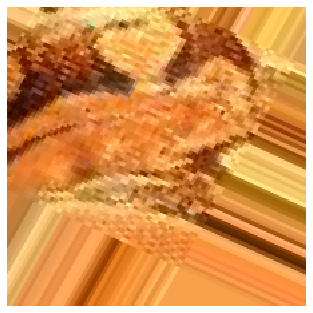

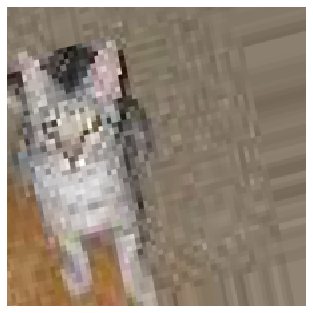

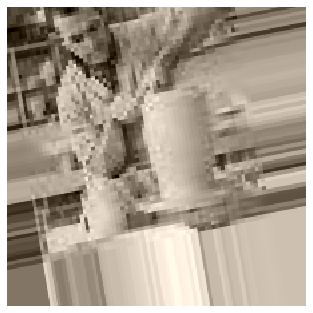

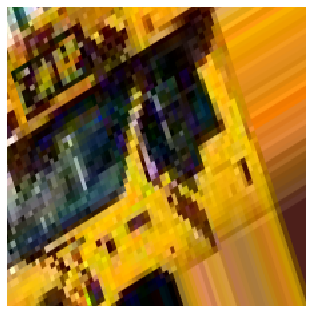

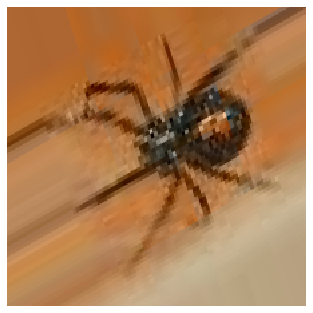

In [5]:
for (X,y) in train_gen:
    print(X.shape,y.shape)
    for i in range(5):
        plt.imshow(X[i])
        plt.axis('off')
        plt.show()
    break

In [6]:
import os
def load_validation(target_size,no_of_classes):
    with open(os.path.join("tiny-imagenet-200/val/val_annotations.txt")) as f:
        lines = f.readlines()
        m = len(lines)
        X = np.empty((m,*target_size,3),dtype=np.uint8)
        y = np.empty(m)
        
        for i,line in enumerate(lines):
            token = line.split()
            img_name = token[0]
            img_label = token[1]
            
            img_url = os.path.join("tiny-imagenet-200/val/images/{}".format(img_name))
            img = image.load_img(img_url)
            img = img.resize(target_size)
            X[i,] = np.array(img,dtype=np.float32)/255.0
            img.close()
            y[i] = class_ids[img_label]
        return X,keras.utils.to_categorical(y,num_classes=no_of_classes)

In [7]:
X_val,y_val = load_validation((224,224),200)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Activation,Dropout
from keras import optimizers
from keras.layers.normalization import BatchNormalization

In [21]:
model = Sequential()
model.add(Conv2D(filters=96,input_shape=(224,224,3),kernel_size=(11,11),strides=(4,4),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2),padding='valid'))

model.add(Conv2D(filters=256,kernel_size=(11,11),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2),padding='valid'))

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2),padding='valid'))

model.add(Flatten())
model.add(Dense(4096,input_shape=(224*224*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(200))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_38 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_39 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 6, 384)        

In [ ]:
adam = optimizers.adam(lr=1e-4)
model.compile(optimizer =adam ,metrics=["accuracy"],loss='categorical_crossentropy')

history = model.fit_generator(train_gen,epochs=60,steps_per_epoch=7,validation_data=(X_val,y_val),validation_steps=4)

Epoch 1/60
7/7 [==============================] - 337s 48s/step - loss: 5.2988 - accuracy: 0.0056 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 2/60
7/7 [==============================] - 312s 45s/step - loss: 5.3016 - accuracy: 0.0045 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/60
6/7 [========================>.....] - ETA: 8s - loss: 5.2988 - accuracy: 0.0052 

In [ ]:
for key,values in (history.history).items():
    plt.plot(values,label = key)
    plt.xlabel("Epoch")
    plt.ylabel("Validation")
    plt.legend()
    plt.title(key)
    #plt.show()

loss,acc = model.evaluate()
print(acc*100)